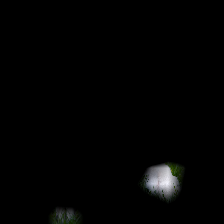

In [13]:
import numpy as np
import cv2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
import keras.backend as K
import tensorflow as tf
from IPython.display import Image, display

tf.compat.v1.disable_eager_execution()

# Load the VGG16 model
model = VGG16(weights='imagenet')

# Load the input image
img_path = 'dog.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get the output of the last convolutional layer
last_conv_layer = model.get_layer('block5_conv3')

# Compute the gradient of the output with respect to the feature maps of the last convolutional layer
grads = K.gradients(model.output[:, 386], last_conv_layer.output)[0]

# Compute the mean of the gradient over each feature map
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Define a function that returns the CAM given an input image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

# Compute the CAM by weighting the feature maps by the corresponding gradient importance weights
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

cam = np.sum(conv_layer_output_value, axis=-1)

img.save('intermediate.jpg')
img = np.array(img)


# Resize the CAM to the size of the input image
cam = cv2.resize(cam, (img.shape[1], img.shape[0]))

# Apply a ReLU activation function to the CAM to obtain only positive values
cam = np.maximum(cam, 0)

# Normalize the CAM to the range [0, 1]
cam = cam / cam.max()

# Convert the input image to a numpy array
img_array = image.img_to_array(img)

# Multiply each pixel in the input image by its corresponding CAM value
for i in range(3):
    img_array[:,:,i] *= cam

# Convert the numpy array back to an image
blended_img = image.array_to_img(img_array)

# Save the blended image
blended_img.save('example_blended_image.jpg')

display(blended_img)